# Применение машинного обучения в бизнесе

**Проект для добывающей компании «ГлавРосГосНефть»**  
**Задача:** Найти лучшую скважину для разработки и добычи  
**Шаги для выбора локации:**  
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.


В данном проекте для предсказания объемов залежи будем использовать линейную регрессию с градиентным бустингом. Для поиска распределения прибыли будем использовать процедуру bootstrap с 1000 итераций.  


**Ожидаемые результаты:**  
1. Линейная модель для предсказания размера залежи;
2. Предполагаемый средний доход по выбранным регионам с 95% доверительным интервалом
3. Рекомендации для компании по полученным результатам
    

## Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Загрузка функций и констант

In [2]:
# строит гистограммы и боксплоты рядом для выбранных столбцов с помощью subplots
def boxplot_vs_hist_subplots(data,list_columns,x,y,title_list,xlabel_list,subtitle):
    import seaborn as sns
    import matplotlib.pyplot as plt
    color = sns.color_palette('Set2',2*len(list_columns))
   
    axes = plt.figure(figsize=(x, y))
    plt.suptitle(subtitle, y=0.9, fontsize='xx-large')

    a = len(list_columns) * 2
    i = 2
    k = 0
    for name in list_columns:
        plt.subplot(a,2,i)
        sns.boxplot(data[name], color=color[k], orient = 'h')
        #plt.boxplot(data[name])
        plt.title(title_list[k])
        plt.xlabel(xlabel_list[k])
        i += 2
        k += 1
    i = 1
    k = 0
    for name in list_columns:
        plt.subplot(a,2,i)
        sns.histplot(data[name], color=color[k])
        plt.title(title_list[k])
        plt.ylabel('Количество')
        plt.xlabel(xlabel_list[k])
        i += 2
        k += 1

In [3]:
RANDOM_STATE = 42

## Загрузка данных

In [4]:
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Просмотр данных

In [5]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<b> Данные загружены верно, ошибок нет.

### Типы данных

In [8]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<b> Типы данных верны

### Дубликаты

In [11]:
print('Дубликатов в geo_data_0:',geo_data_0.duplicated().sum())
print('Дубликатов в geo_data_1:',geo_data_1.duplicated().sum())
print('Дубликатов в geo_data_2:',geo_data_2.duplicated().sum())

Дубликатов в geo_data_0: 0
Дубликатов в geo_data_1: 0
Дубликатов в geo_data_2: 0


<b> Явных дубликатов в данных нет

### Пропуски

In [12]:
print('Пропусков в geo_data_0:',geo_data_0.isna().sum(),sep='\n')

Пропусков в geo_data_0:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [13]:
print('Пропусков в geo_data_1:',geo_data_1.isna().sum(),sep='\n')

Пропусков в geo_data_1:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [14]:
print('Пропусков в geo_data_1:',geo_data_2.isna().sum(),sep='\n')

Пропусков в geo_data_1:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


<b> Пропусков в данных не обнаружено

<b> Во время предобработки данных было выяснено:
1. Все данные имеют правильный тип.
2. Столбцы имеют удобные названия 
3. Данные содержат небольшое количество пропусков и не имеют явных дубликатов

## Исследовательский анализ

### Регион 0

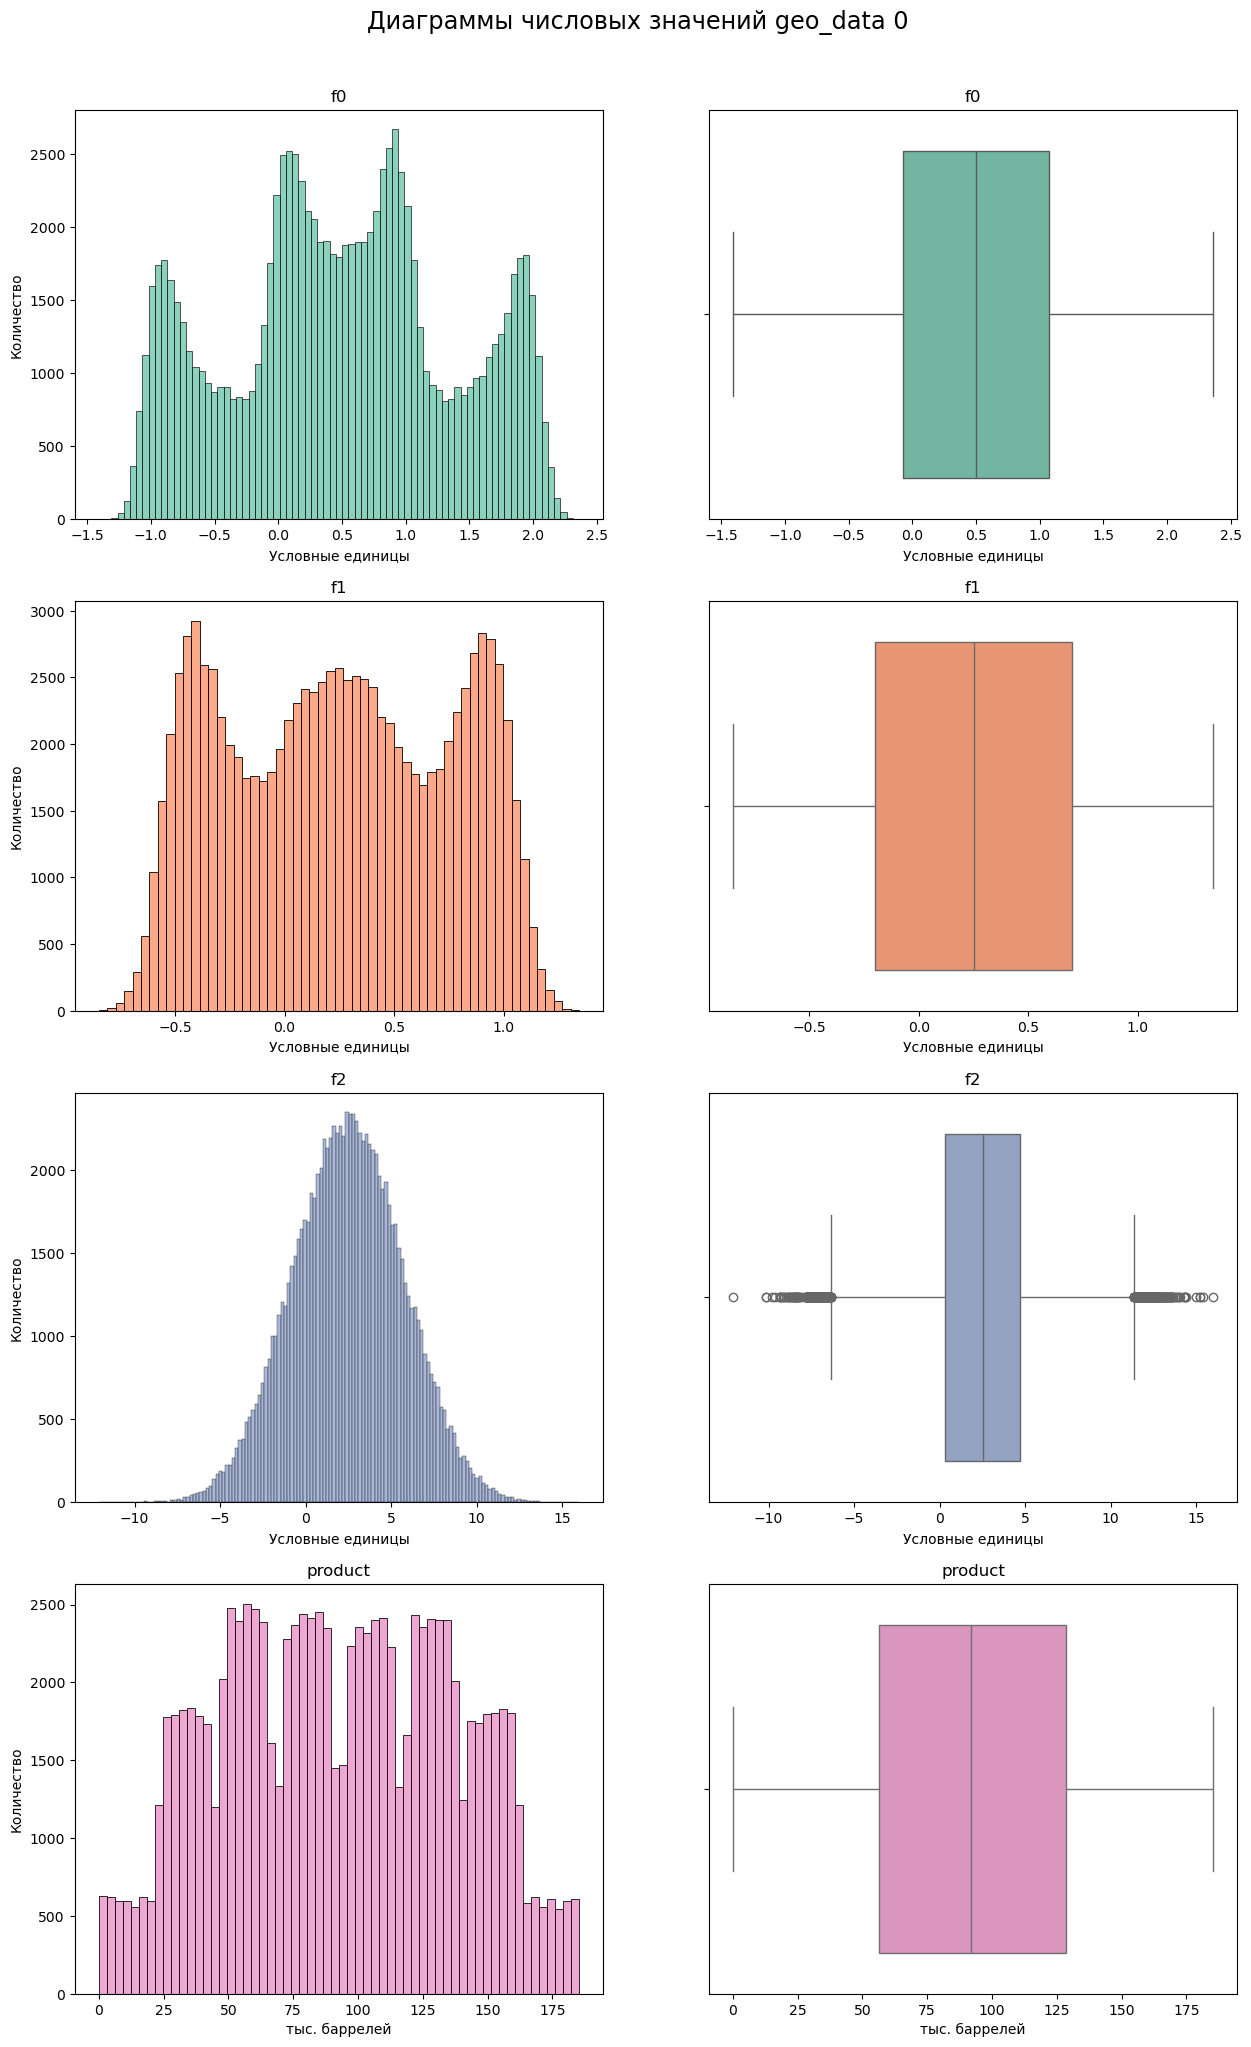

In [15]:
columns = ['f0','f1','f2','product']
boxplot_vs_hist_subplots(geo_data_0,columns,15,50,columns,['Условные единицы','Условные единицы','Условные единицы','тыс. баррелей'],'Диаграммы числовых значений geo_data 0')

In [16]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


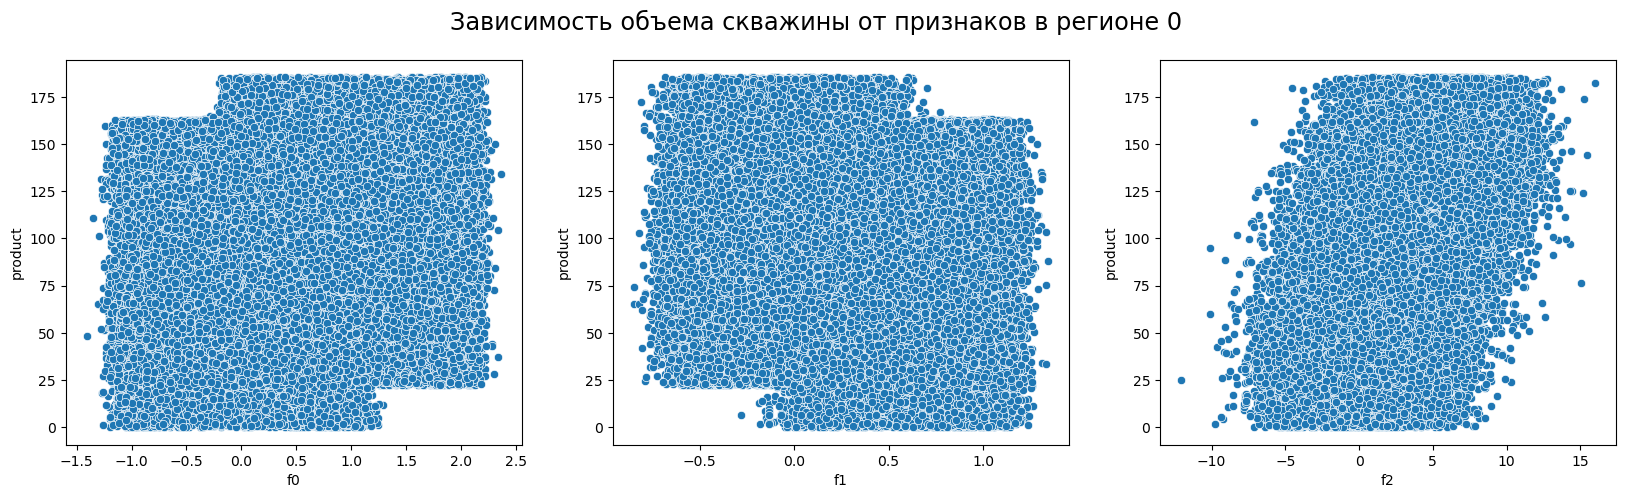

In [17]:
plt.figure(figsize=(20,5))
plt.suptitle('Зависимость объема скважины от признаков в регионе 0', fontsize='xx-large')
plt.subplot(1,3,1)
sns.scatterplot(data = geo_data_0, x = 'f0', y = 'product')
plt.subplot(1,3,2)
sns.scatterplot(data = geo_data_0, x = 'f1', y = 'product')
plt.subplot(1,3,3)
sns.scatterplot(data = geo_data_0, x = 'f2', y = 'product')
plt.show()

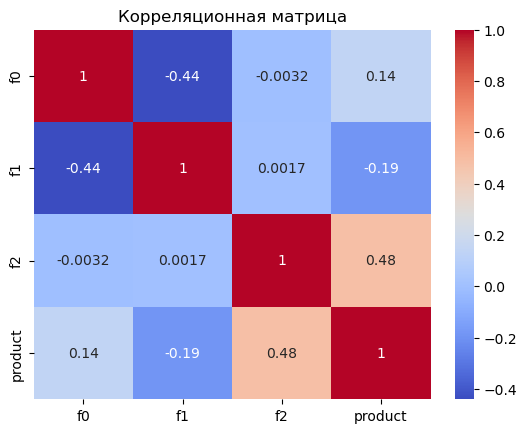

In [18]:
sns.heatmap(geo_data_0[['f0','f1','f2','product']].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

### Выводы по 0 региону

**Распределенеи признаков:**
- f0: Наблюдаем распределенеие с 4 четкими пиками. Среднее значение: 0.5
- f1: Распределение имеет 3 пика. Среднее значение: 0.25
- f2: Обладает нормальным распределением с центром в 2.5.
- product: Распределение объема скважины распределено аналогично f0 и f1, но обладает 6 пиками и четким ненулевым минимальным значением. Среднее значение: 92.5


**Корреляция:**  
Наблюдается средняя корреляция между f2 и product. Однако, четкой линейной связи не наблюдается. Линейная регрессия по таким данным будет обладать пониженной точностью.

### Регион 1

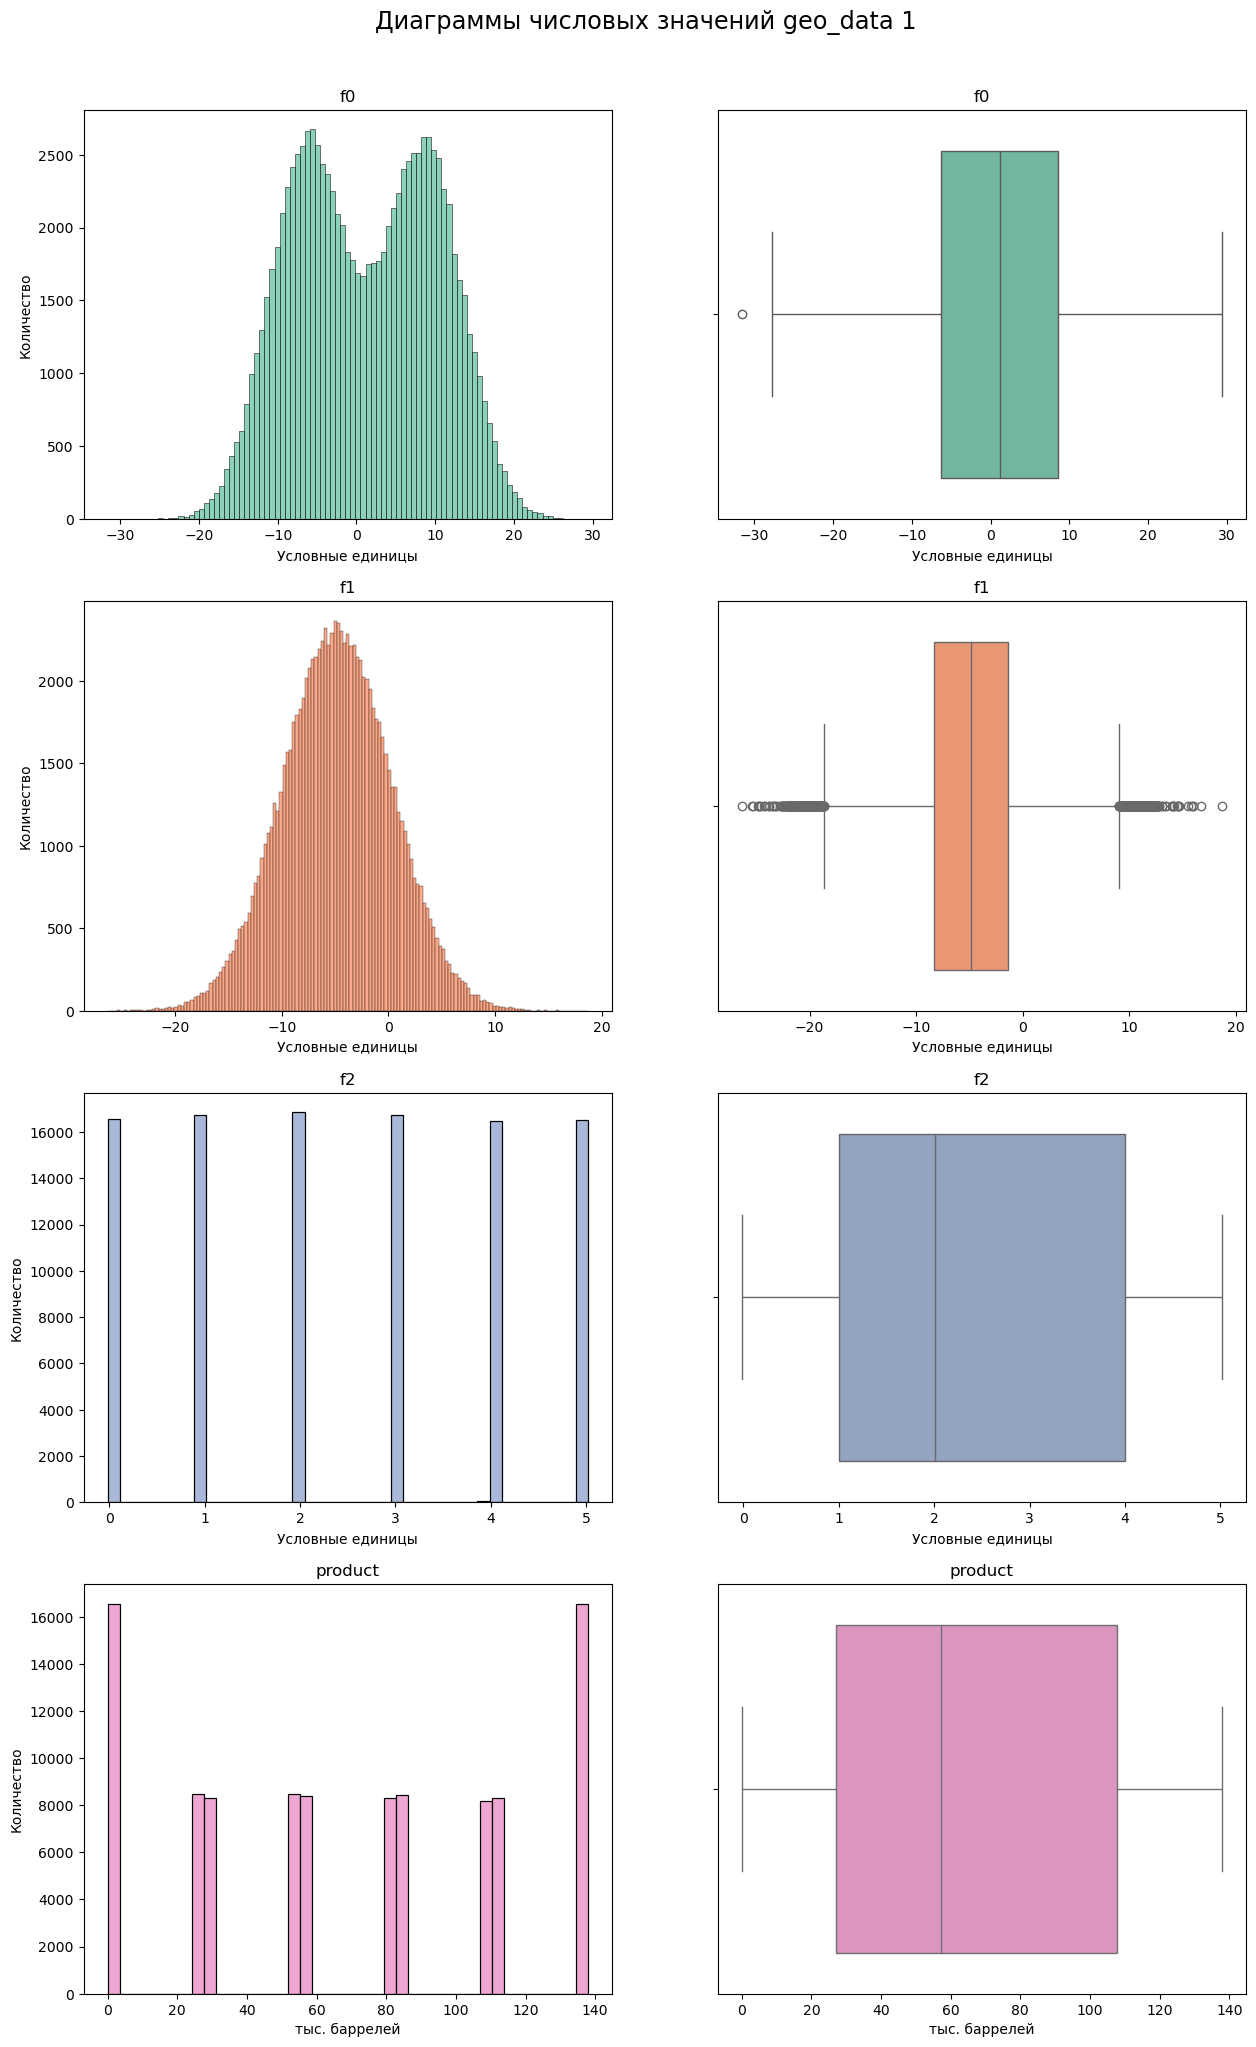

In [19]:
boxplot_vs_hist_subplots(geo_data_1,columns,15,50,columns,['Условные единицы','Условные единицы','Условные единицы','тыс. баррелей'],'Диаграммы числовых значений geo_data 1')

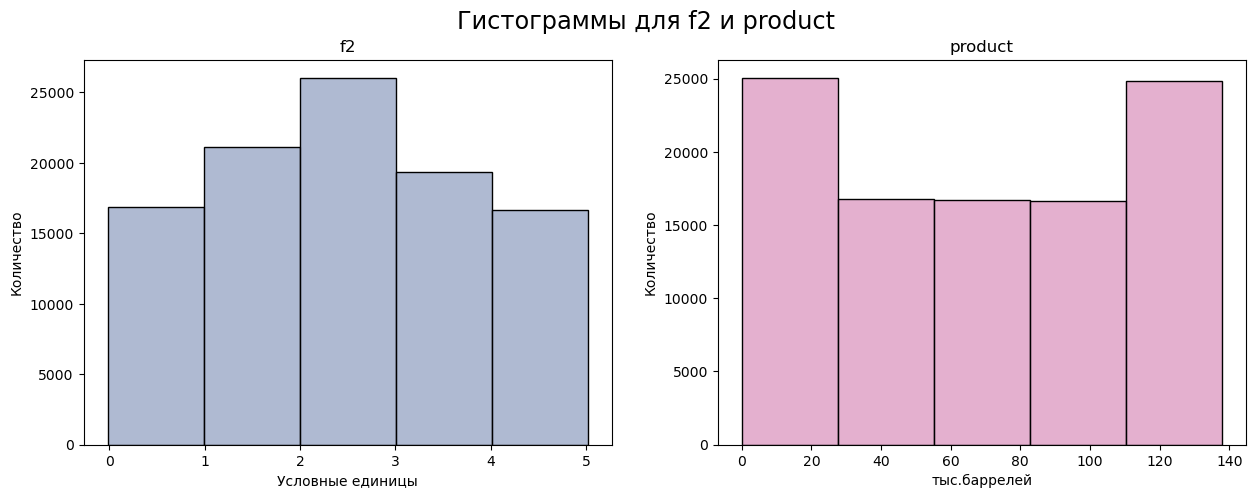

In [20]:
plt.figure(figsize=(15,5))
plt.suptitle('Гистограммы для f2 и product', fontsize = 'xx-large')
plt.subplot(1,2,1)
plt.xlabel('Условные единицы')
plt.ylabel('Количество')
plt.title('f2')
sns.histplot(data=geo_data_1['f2'],bins=5,color = '#95a3c3')
plt.subplot(1,2,2)
sns.histplot(data=geo_data_1['product'],bins=5,color = '#db96c0')
plt.xlabel('тыс.баррелей')
plt.ylabel('Количество')
plt.title('product')
plt.show()

In [21]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


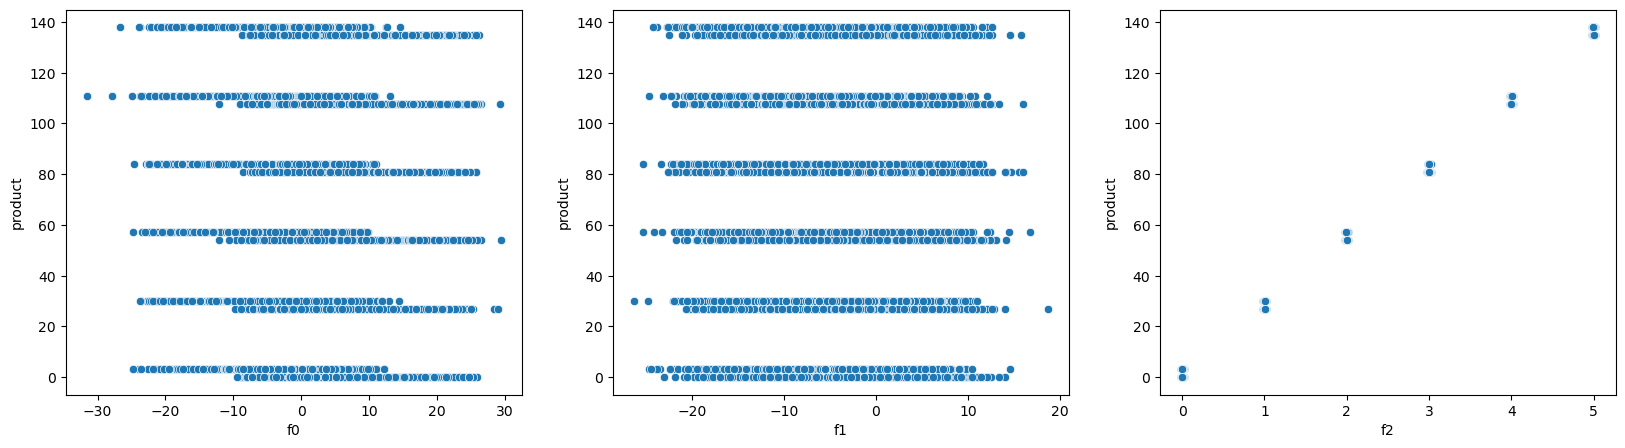

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(data = geo_data_1, x = 'f0', y = 'product')
plt.subplot(1,3,2)
sns.scatterplot(data = geo_data_1, x = 'f1', y = 'product')
plt.subplot(1,3,3)
sns.scatterplot(data = geo_data_1, x = 'f2', y = 'product')
plt.show()


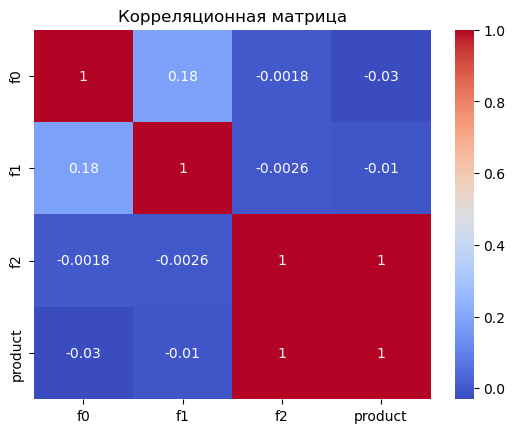

In [23]:
sns.heatmap(geo_data_1[['f0','f1','f2','product']].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

### Выводы по 1 региону

**Распределенеи признаков:**
- f0: Наблюдаем симметричное бимодальное распределенеие с пиками вблизи -10 и 10. Среднее значение: 1.1
- f1: Нормальное распределение. Среднее значение: -4.8
- f2 и product: Распределение можно разделить на 5 отдельных интервалы. Описательная статистика непоказательна


**Корреляция:**  
Наблюдается сильная корреляция между f2 и product. Наблюдается очень четкая линейная зависимость. Следовательно, точность линейной модели будет максимальна.

### Регион 2

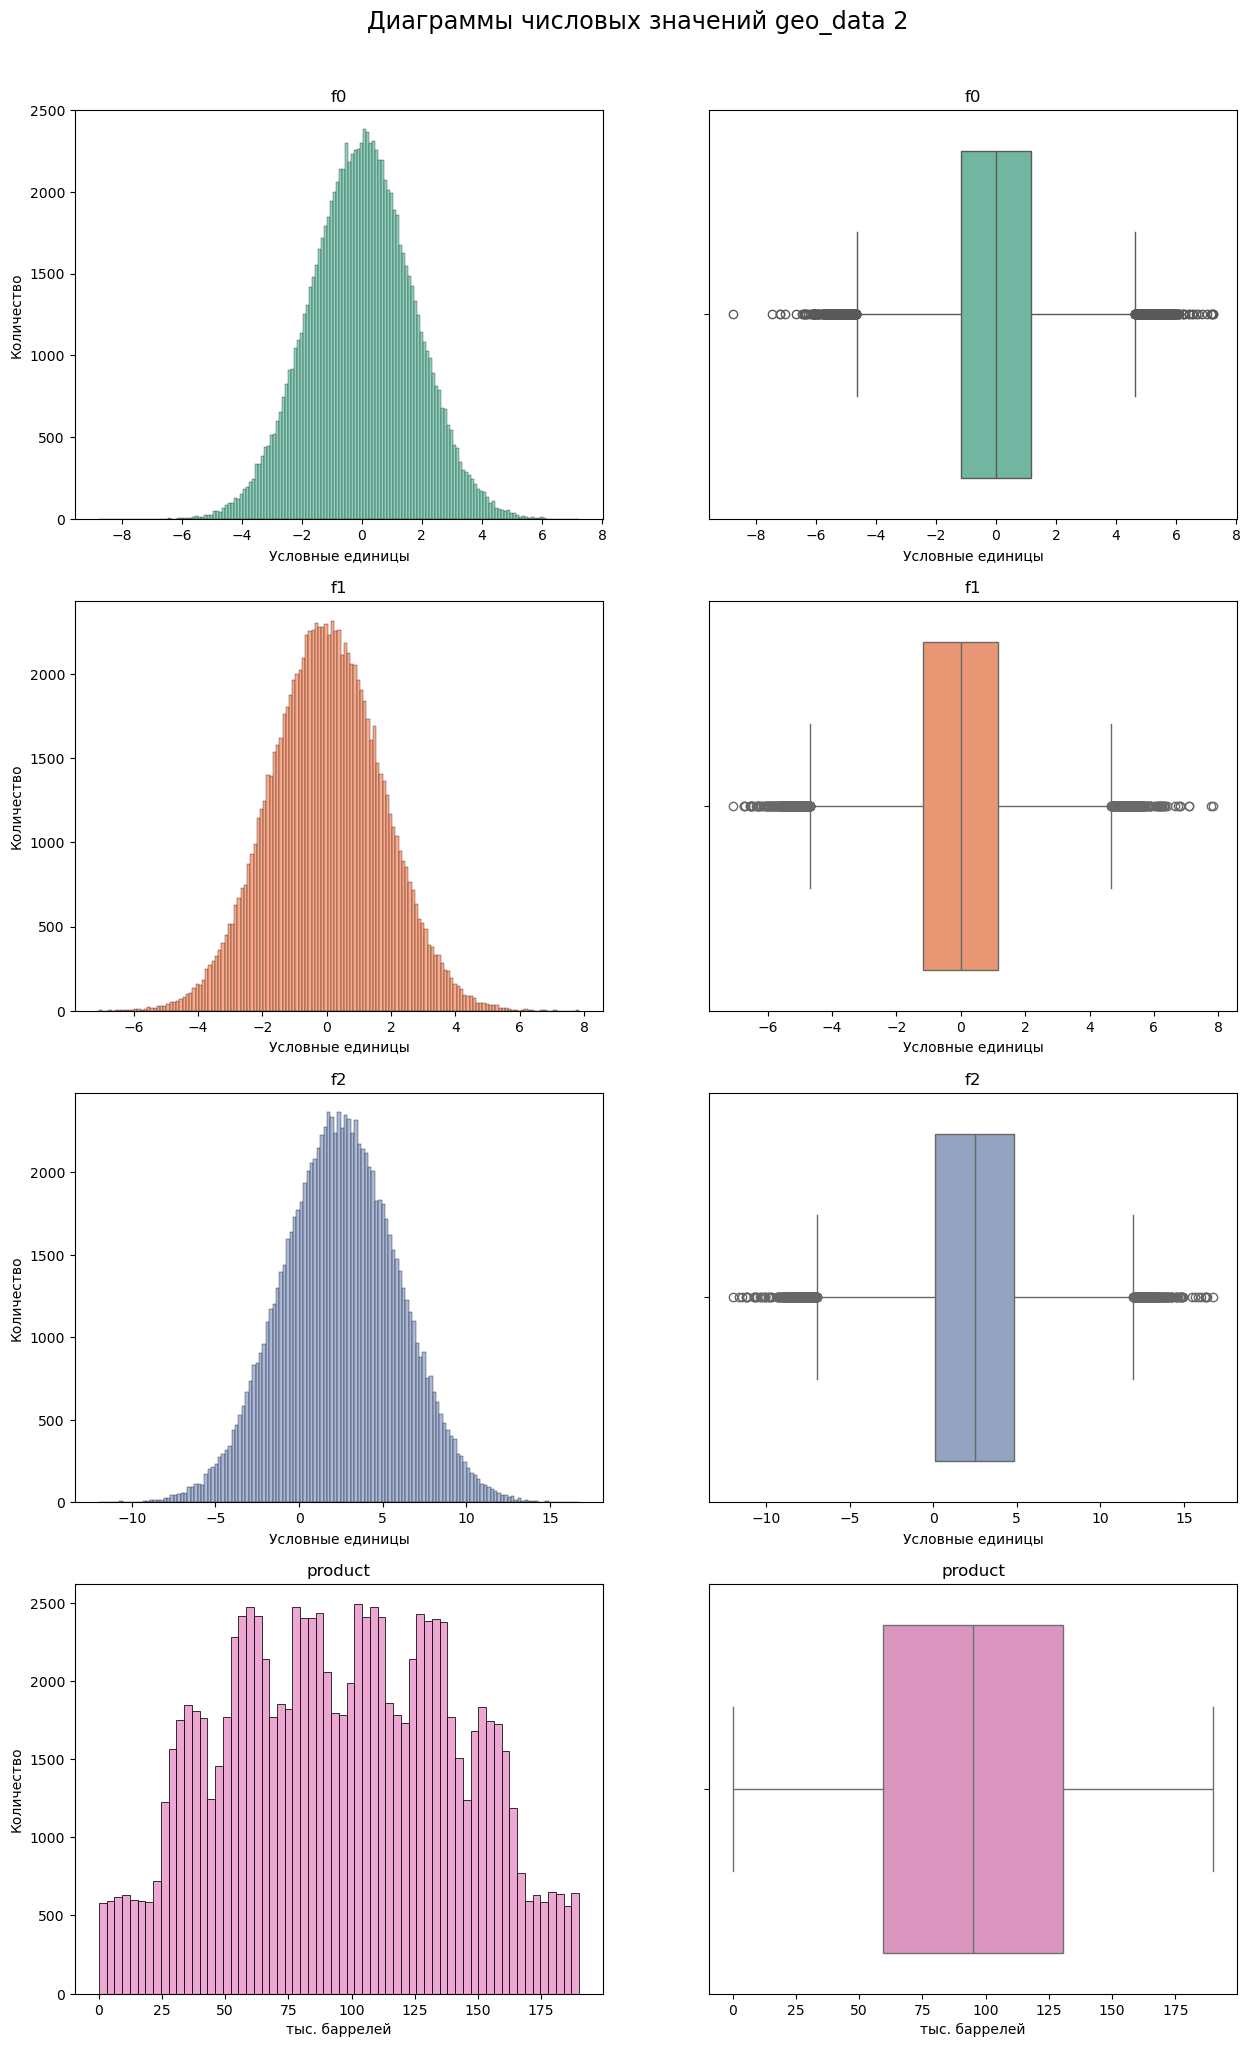

In [24]:
boxplot_vs_hist_subplots(geo_data_2,columns,15,50,columns,['Условные единицы','Условные единицы','Условные единицы','тыс. баррелей'],'Диаграммы числовых значений geo_data 2')

In [25]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


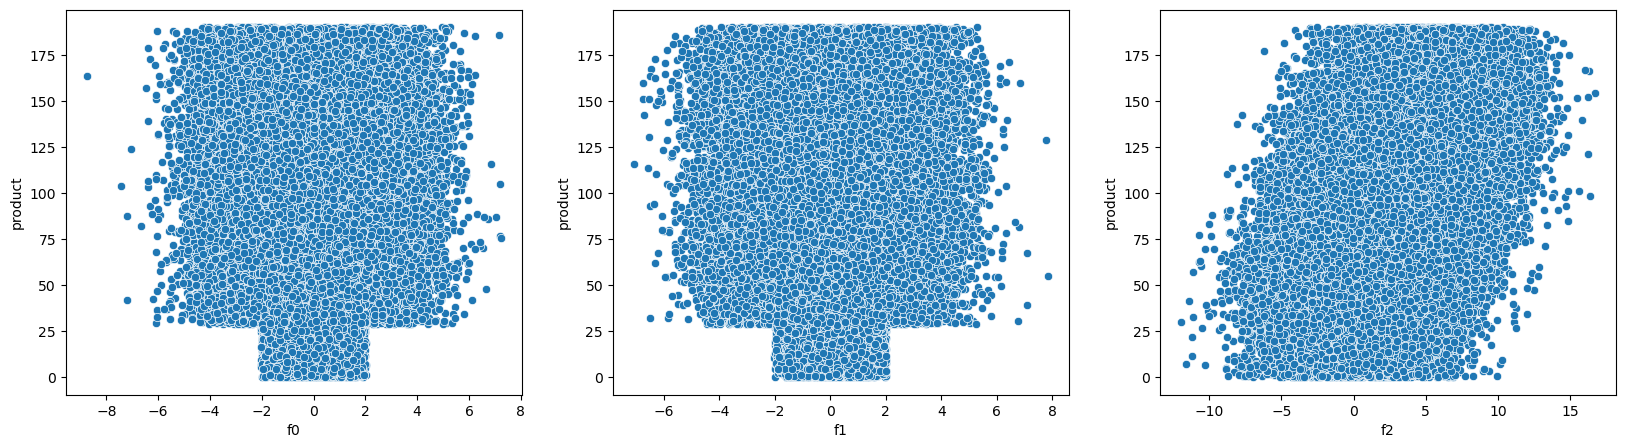

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(data = geo_data_2, x = 'f0', y = 'product')
plt.subplot(1,3,2)
sns.scatterplot(data = geo_data_2, x = 'f1', y = 'product')
plt.subplot(1,3,3)
sns.scatterplot(data = geo_data_2, x = 'f2', y = 'product')
plt.show()


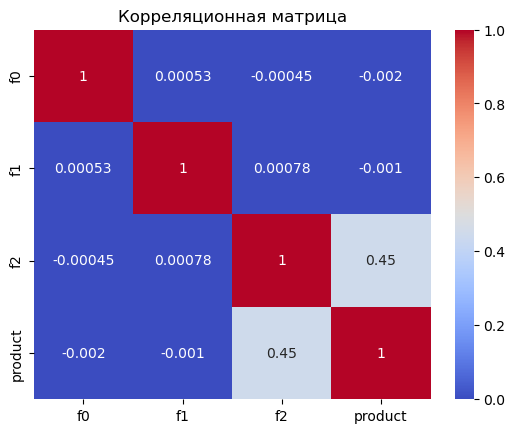

In [27]:
sns.heatmap(geo_data_2[['f0','f1','f2','product']].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

### Выводы по 2 региону

**Распределенеи признаков:**
- f0,f1,f2: Наблюдаем нормальное распределение. Средние значения: 0.002023, -0.002081, 2.495128, соотвественно.
- product: Распределение снова обладает различимыми пиками с ненулевым минимальным порогом. Среднее значение: 95. 


**Корреляция:**  
Наблюдается средняя корреляция между f2 и product. Аналогично 0 региону.

## Подготовка данных

<b> Многие признаки в датасетах распределены нормально в широком диапазоне значений. значения, выходящие за концы боксплотов, могут мешать обучению.  
Признаки для коррекции:  
 - **data_geo_0: f2**
 - **data_geo_1: f0, f1**
 - **data_geo_2: f0, f1, f2**

In [28]:
def only_ci(data,names):
    import pandas as pd
    data_new = pd.DataFrame
    start_quant = []
    end_quant = []
    for name in names:
        start_quant.append(data[name].quantile(0.25) - 1.5*(data[name].quantile(0.75) - data[name].quantile(0.25)))
        end_quant.append(data[name].quantile(0.75) + 1.5*(data[name].quantile(0.75) - data[name].quantile(0.25)))
    
    for name,start,stop in zip(names,start_quant,end_quant):
        data_new = data[(data[name] >= start)&(data[name] <= stop)]
    return data_new

In [29]:
#geo_data_0 = only_ci(geo_data_0,['f2'])
#geo_data_1 = only_ci(geo_data_1,['f0','f1'])
#geo_data_2 = only_ci(geo_data_2,['f0','f1','f2'])

In [30]:
print(f'Удалено из geo_data_0 {(1 - len(geo_data_0)/100000) :.2%}')
print(f'Удалено из geo_data_1 {(1 - len(geo_data_1)/100000) :.2%}')
print(f'Удалено из geo_data_2 {(1 - len(geo_data_2)/100000) :.2%}')

Удалено из geo_data_0 0.00%
Удалено из geo_data_1 0.00%
Удалено из geo_data_2 0.00%


<b> Вывод из будущего: удаление маловероятных значений из нормальных распределений значиительно завышает прибыль по региону(на 12 миллионов рублей). Для планирования финансовой модели такое абослютно неприемлимо. Оставим данные значения и проведем подготовку данных методом RobustScaler для минимизации негативного эффекта. Применим метод при построении моделей.

## Разделение выборок

In [31]:
geo_data_0_features_train, geo_data_0_features_test, geo_data_0_target_train, geo_data_0_target_test = train_test_split(geo_data_0.drop('product',axis=1),geo_data_0[['id','product']], 
                                                                                                                        test_size=0.25, random_state=RANDOM_STATE)

In [32]:
geo_data_1_features_train, geo_data_1_features_test, geo_data_1_target_train, geo_data_1_target_test = train_test_split(geo_data_1.drop('product',axis=1),geo_data_1[['id','product']], 
                                                                                                                        test_size=0.25, random_state=RANDOM_STATE)

In [33]:
geo_data_2_features_train, geo_data_2_features_test, geo_data_2_target_train, geo_data_2_target_test = train_test_split(geo_data_2.drop('product',axis=1),geo_data_2[['id','product']], 
                                                                                                                        test_size=0.25, random_state=RANDOM_STATE)

## Обучение моделей

In [34]:
pipe_0 = Pipeline([('scale', RobustScaler()), ('model',SGDRegressor(max_iter=1000, tol=1e-3, random_state=RANDOM_STATE))])
pipe_1 = Pipeline([('scale', RobustScaler()), ('model',SGDRegressor(max_iter=1000, tol=1e-3, random_state=RANDOM_STATE))])
pipe_2 = Pipeline([('scale', RobustScaler()), ('model',SGDRegressor(max_iter=1000, tol=1e-3, random_state=RANDOM_STATE))])

### Регион 0

In [35]:
pipe_0.fit(geo_data_0_features_train.drop('id',axis=1), geo_data_0_target_train['product'])
geo_0_preds = pipe_0.predict(geo_data_0_features_test.drop('id',axis=1))
print(f'RMSE для 0 региона = {mean_squared_error(geo_0_preds, geo_data_0_target_test["product"], squared = False):.5}')
print(f'Средний предсказанный запас в 0 регионе = {geo_0_preds.mean():.5}')
print(f'Истинный средний запас в 0 регионе = {geo_data_0_target_test["product"].mean():.5}')

RMSE для 0 региона = 37.765
Средний предсказанный запас в 0 регионе = 92.619
Истинный средний запас в 0 регионе = 92.326


### Регион 1

In [36]:
pipe_1.fit(geo_data_1_features_train.drop(['id'],axis=1), geo_data_1_target_train['product'])
geo_1_preds = pipe_1.predict(geo_data_1_features_test.drop(['id'],axis=1))
print(f'RMSE для 1 региона = {mean_squared_error(geo_1_preds, geo_data_1_target_test["product"], squared = False):.3}')
print(f'Средний предсказанный запас в 1 регионе = {geo_1_preds.mean():.5}')
print(f'Истинный средний запас в 1 регионе = {geo_data_1_target_test["product"].mean():.5}')

RMSE для 1 региона = 0.89
Средний предсказанный запас в 1 регионе = 68.721
Истинный средний запас в 1 регионе = 68.725


### Регион 2

In [37]:
pipe_2.fit(geo_data_2_features_train.drop('id',axis=1), geo_data_2_target_train['product'])
geo_2_preds = pipe_2.predict(geo_data_2_features_test.drop('id',axis=1))
print(f'RMSE для 2 региона = {mean_squared_error(geo_2_preds, geo_data_2_target_test["product"], squared = False):.5}')
print(f'Средний предсказанный запас в 2 регионе = {geo_2_preds.mean():.5}')
print(f'Истинный средний запас в 2 регионе = {geo_data_2_target_test["product"].mean():.5}')

RMSE для 2 региона = 40.162
Средний предсказанный запас в 2 регионе = 94.366
Истинный средний запас в 2 регионе = 95.151


**Выводы**  
Лучше всего себя показала модель предсказания, обученная на регионе 1. Среднеквадратичная ошибка ошибка минимальна, что делает полученный прогноз наиболее точным.    


**Регион 0:** Средний запас: 93.2, среднеквадратичная ошибка: 37.8  
**Регион 1:** Средний запас: 68.7, среднеквадратичная ошибка: 0.89  
**Регион 2:** Средний запас: 94.4, среднеквадратичная ошибка: 40.2  


### Сохранение результатов

In [38]:
geo_data_0_target_test['predicted'] = geo_0_preds
geo_data_1_target_test['predicted'] = geo_1_preds
geo_data_2_target_test['predicted'] = geo_2_preds

## Анализ результатов

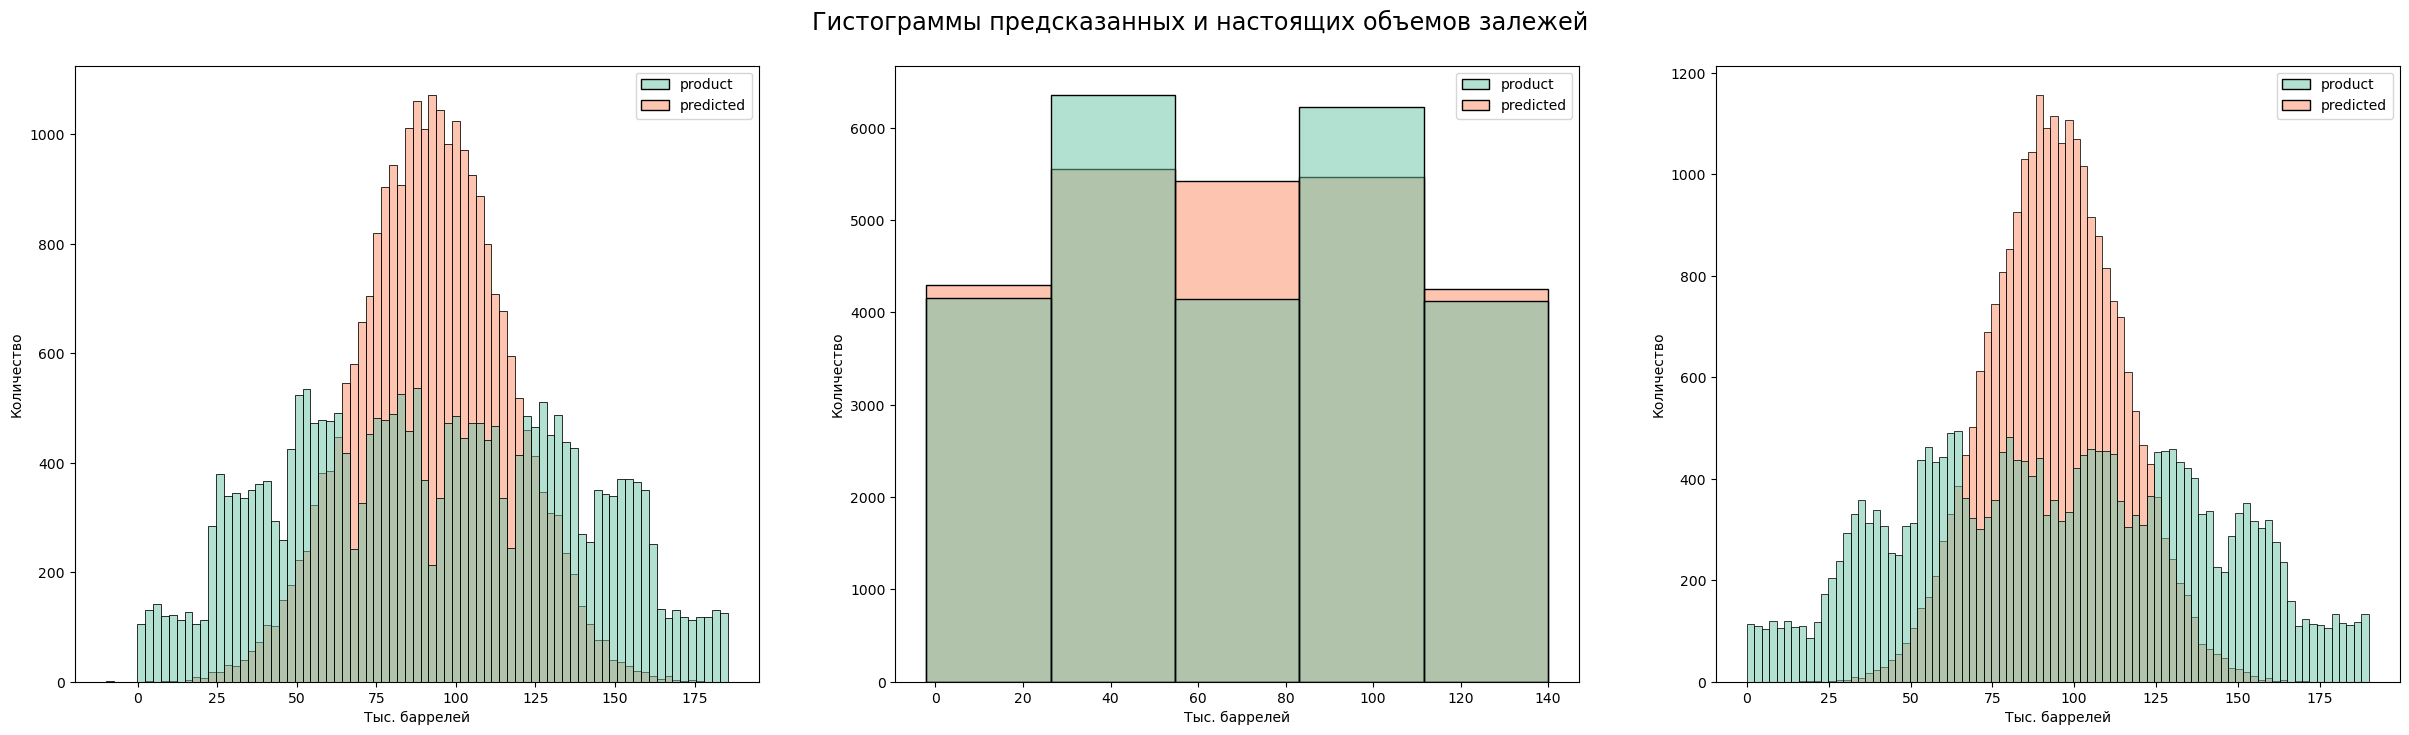

In [39]:
plt.figure(figsize=(30,8))
plt.suptitle('Гистограммы предсказанных и настоящих объемов залежей', y=0.95, fontsize='xx-large')
plt.subplot(1,3,1)
plt.xlabel('Тыс. баррелей')
plt.ylabel('Количество')
sns.histplot(geo_data_0_target_test, palette = 'Set2')
plt.subplot(1,3,2)
plt.xlabel('Тыс. баррелей')
plt.ylabel('Количество')
sns.histplot(geo_data_1_target_test, bins = 5, palette = 'Set2')
plt.subplot(1,3,3)
plt.xlabel('Тыс. баррелей')
plt.ylabel('Количество')
sns.histplot(geo_data_2_target_test, palette = 'Set2')
plt.show()

<b> Ошибки моделей на 0 и 2 регионе обусловлены значениями коэф. Пирсона. Предсказанные значения имеют нормальное распределение, когда реальные данные обладают сложным распределением с разделимыми пиками. В случае 1 региона, предсказанные данные обладают схожим типом распределения.

## Рассчет достаточного объёма сырья для безубыточной разработки новой скважины

In [40]:
regional_budget = 10**10
research_volume = 500
selected_volume = 200
income_per_unit = 450000
probability_loss = 0.025

In [41]:
min_product = (regional_budget/selected_volume)/income_per_unit
print(f'Минимальный объем скважины = {min_product:.6} тыс.баррелей')

Минимальный объем скважины = 111.111 тыс.баррелей


**По результатам расчета минимальный объем сырья должен составить 112 тыс.баррелей. Средние запасы скважин во всех трех регионах меньше данного значения, следовательно, необходимо учитывать возможность убытков**

## Расчёт прибыли по выбранным скважинам и предсказаниям модели

**Допустим, известны параметры скважин в регионе. С помощью модели выберем 200 лучший, проведем разработку и рассчитаем прибыль**

In [42]:
def income_calc(data, *, selected_volume=200, income_per_unit=450000, investion = 10**10):
    selected = pd.DataFrame
    selected = data.sort_values(by='predicted',ascending = False).head(selected_volume)['product']
    income = selected.sum() * income_per_unit - investion
    return income

In [43]:
print(f'Прибыль 200 лучших скважин 0 региона = {round(income_calc(geo_data_0_target_test)/1000000,2)} млн.руб.')
print(f'Прибыль 200 лучших скважин 1 региона = {round(income_calc(geo_data_1_target_test)/1000000,2)} млн.руб.')
print(f'Прибыль 200 лучших скважин 2 региона = {round(income_calc(geo_data_2_target_test)/1000000,2)} млн.руб.')

Прибыль 200 лучших скважин 0 региона = 3441.3 млн.руб.
Прибыль 200 лучших скважин 1 региона = 2415.09 млн.руб.
Прибыль 200 лучших скважин 2 региона = 2590.44 млн.руб.


## Поиск распределения прибыли методом Bootstrap

In [44]:
def income_distribution(data, *, n=1000, research_volume=500, selected_volume=200, income_per_unit=450000, investion = 10**10):
    RANDOM_STATE = np.random.RandomState(12345)
    values = []
    for i in range(n):
        sample = data.sample(research_volume, replace=True, random_state=RANDOM_STATE)
        values.append(income_calc(sample))
    values = pd.Series(values)
    mean = values.mean()
    start_q = values.quantile(q=0.025)
    stop_q = values.quantile(q=0.975)
    loss_risk = len(values[values < 0]) / len(values) * 100
    return [round(mean,2),round(start_q,2),round(stop_q,2),loss_risk]

In [45]:
i = 0
for name in [geo_data_0_target_test,geo_data_1_target_test,geo_data_2_target_test]:
    print(f'Распределение прибыли для {i} региона')
    print(f'Среднее: {round(income_distribution(name)[0]/1000000,2)} млн.руб.')
    print(f'95% CI: {round(income_distribution(name)[1]/1000000,2)} - {round(income_distribution(name)[2]/1000000,2)} млн.руб.')
    print(f'Риск убытков: {round(income_distribution(name)[3],2)} %')
    print('')
    i += 1

Распределение прибыли для 0 региона
Среднее: 405.4 млн.руб.
95% CI: -131.6 - 893.04 млн.руб.
Риск убытков: 6.8 %

Распределение прибыли для 1 региона
Среднее: 432.62 млн.руб.
95% CI: 16.85 - 815.97 млн.руб.
Риск убытков: 1.9 %

Распределение прибыли для 2 региона
Среднее: 372.02 млн.руб.
95% CI: -179.91 - 901.17 млн.руб.
Риск убытков: 8.3 %



**Вывод:**  
С помощью метода bootstrap удалось вычислить среднее значение прибыли по разработке 200 лучших скважин в регионах. Оптимальный регион - регион 1. Риск убытков минимален и менее 2.5%. Средняя прибыль составит 432.62 млн.руб. Остальные регионы сравнимы по прибыли, но имеют риск более 2.5%

## Общие выводы

В ходе проекта были исследованы данные по параметрам скважин из трех регионов.   
Данные представлены 
На этих данных были обучены 3 модели линейной регрессии  
**Регион 0**  
RMSE  = 37.832 тыс.баррелей   
Средний предсказанный запас  = 92.62 тыс.баррелей   
Истинный средний запас в = 92.33 тыс.баррелей   
**Регион 1**  
RMSE  = 0.89 тыс.баррелей   
Средний предсказанный запас  = 68.721 тыс.баррелей   
Истинный средний запас  = 68.725 тыс.баррелей   
**Регион 2**  
RMSE  = 40.162 тыс.баррелей   
Средний предсказанный запас  = 94.366 тыс.баррелей   
Истинный средний запас  = 95.151 тыс.баррелей  

Для предсказания прибыли разработки месторождений была использована методика bootstrap.   
Было получено, что **самым перспективным регионом для добычи является 1 регион**. 
- Средняя прибыль: 432.62 млн.руб.
- 95% CI: 16.85 - 815.97 млн.руб.
- Риск убытков: 1.9 %

Регионы 0 и 2 обладают высокими рисками убытков, при близких значениях средней прибыли.